In [27]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

In [28]:
data_T0 = pd.read_csv("QueryResultsFinal.csv")
print(data_T0.shape)

(66769, 12)


## Nettoyage du texte

In [29]:
# Vérifier si la colonne "body_clean" contient des valeurs float
float_values = data_T0['body_clean'][data_T0['body_clean'].apply(lambda x: isinstance(x, float))]
print(float_values)

19729    NaN
Name: body_clean, dtype: object


In [30]:
# on supprimme l'échantillon qui contient un float
data_T0.drop(19729, inplace=True)

In [31]:
l_cat = list(set(data_T0['main_tag']))

y_cat_num = [(1-l_cat.index(data_T0.iloc[i]['main_tag'])) for i in range(len(data_T0))]

In [10]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T0['sentence_bow'] = data_T0['body_clean'].apply(lambda x : transform_bow_fct(x))
data_T0['sentence_bow_lem'] = data_T0['body_clean'].apply(lambda x : transform_bow_lem_fct(x))
data_T0['sentence_dl'] = data_T0['body_clean'].apply(lambda x : transform_dl_fct(x))
data_T0.shape

(66768, 15)

In [18]:
data_T0.head()

,Title,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,body_clean,main_tag,ActivityTime,sentence_bow,sentence_bow_lem,sentence_dl
0,How to convert Decimal to Double in C#?,"['c#', 'floating-point', 'type-conversion', 'd...",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,want assign decimal variable double variable d...,c#,5151,want assign decimal variable double variable d...,want assign decimal variable double variable d...,want assign decimal variable double variable d...
1,Calculate relative time in C#,"['c#', 'datetime', 'time', 'datediff', 'relati...",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,given specific value display relative time lik...,c#,5148,given specific value display relative time lik...,given specific value display relative time lik...,given specific value display relative time lik...
2,Determine a user's timezone,"['html', 'browser', 'timezone', 'user-agent', ...",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,standard way web server able determine user ti...,html,4988,standard way web server able determine user ti...,standard way web server able determine user ti...,standard way web server able determine user ti...
3,How to use the C socket API in C++ on z/OS,"['c++', 'c', 'sockets', 'mainframe', 'zos']",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,issue getting c socket work properly c althoug...,c++,5416,issue getting socket work properly although in...,issue getting socket work properly although in...,issue getting c socket work properly c althoug...
4,Decoding T-SQL CAST in C#/VB.NET,"['c#', 'sql', 'vb.net', 'ascii', 'hex']",109,68,6106,2,2008-08-01 15:23:05,2019-02-10 22:11:00,3,recently site deluged resurgence botnet inject...,c#,3845,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...


In [19]:
data_T0.to_csv("QuerySaveAfterLem.csv")

In [32]:
data_T = pd.read_csv("QuerySaveAfterLem.csv")

## Fonctions communes

In [36]:
data_T = data_T.dropna()

In [33]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tags par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tags par clusters')
    
    plt.show()
    print("ARI : ", ARI)

# Bag of word - Tf-idf

## Préparation sentences

In [37]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])

## Exécution des modèles

In [38]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

# Rapport de classification
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

CountVectorizer : 
-----------------


ValueError: Found input variables with inconsistent numbers of samples: [66768, 66767]

## Graphiques

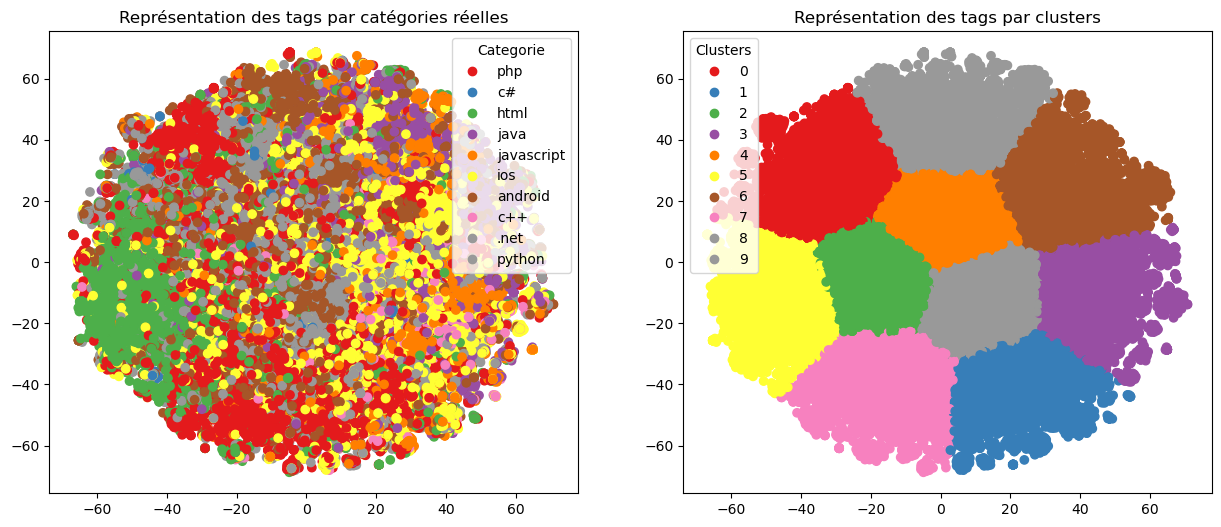

ARI :  0.0533


In [24]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [13]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [14]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [15]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 19656
Word2Vec trained


In [16]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 19657


## Création de la matrice d'embedding

In [17]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (19657, 300)


## Création du modèle d'embedding

In [18]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           5897100   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 5,897,100
Trainable params: 5,897,100
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [19]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

2087/2087 [==============================] - 1s 448us/step


(66768, 300)

In [20]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0287 time :  428.0


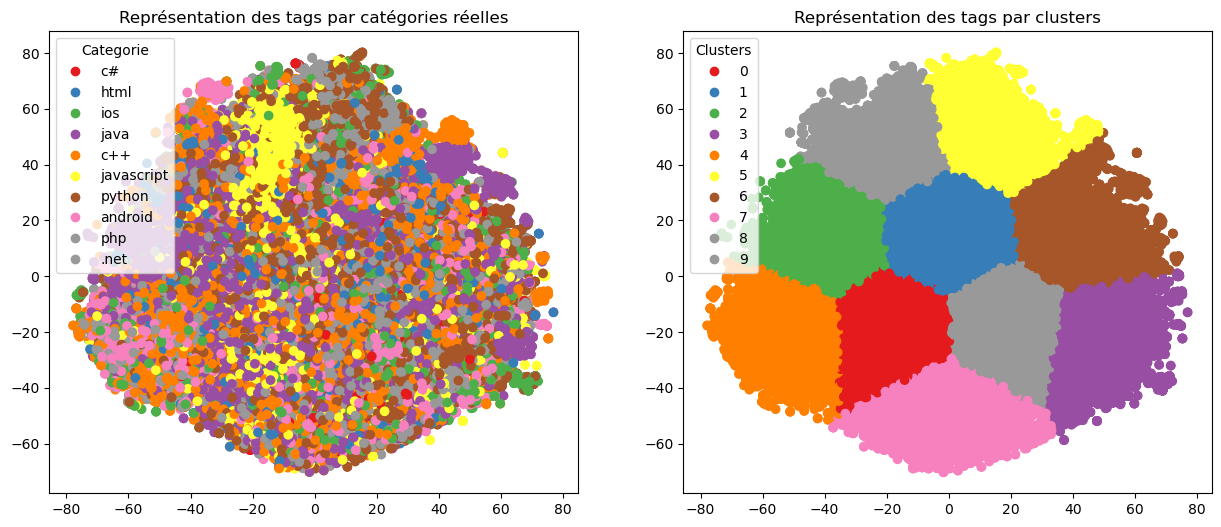

ARI :  0.0287


In [21]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [21]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [27]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

ModuleNotFoundError: No module named 'tensorflow'

In [23]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.10.1
2.10.1
Num GPUs Available:  0
True


## Fonctions communes

In [26]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [34]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa

In [35]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\vocab.t

1/1 [==============================] - 0s 451ms/step
temps traitement :  9.0


In [36]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\omira\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ARI :  0.0419 time :  8.0


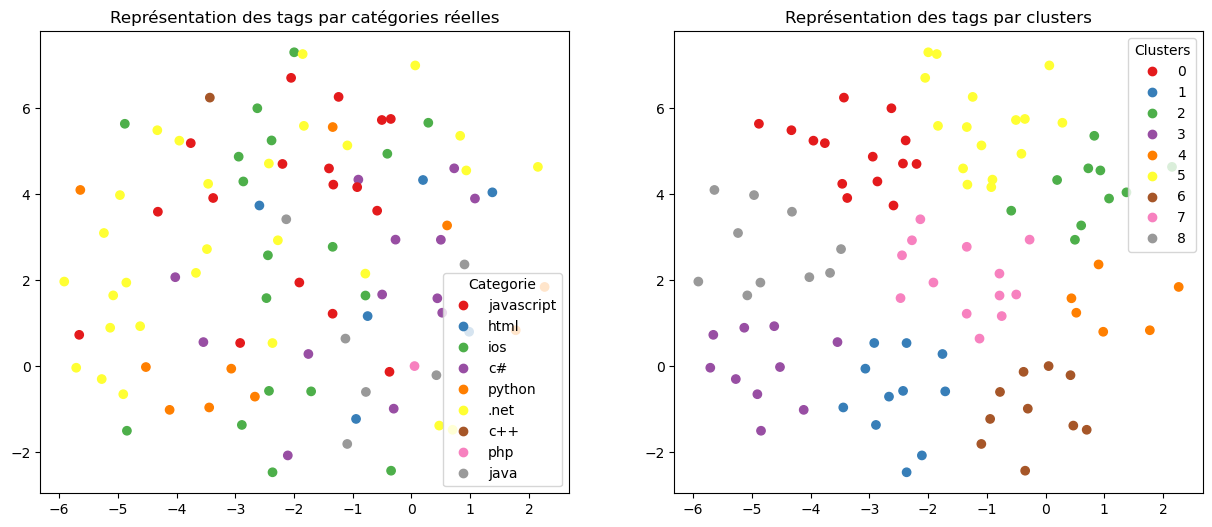

ARI :  0.0419


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [38]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\omira\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\omira\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapsho

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\tf_model.h5
Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was tr

In [39]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

loading file vocab.json from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\vocab.json
loading file merges.txt from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "ca

1/1 [==============================] - 0s 463ms/step
temps traitement :  8.0


In [40]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\omira\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ARI :  0.0142 time :  8.0


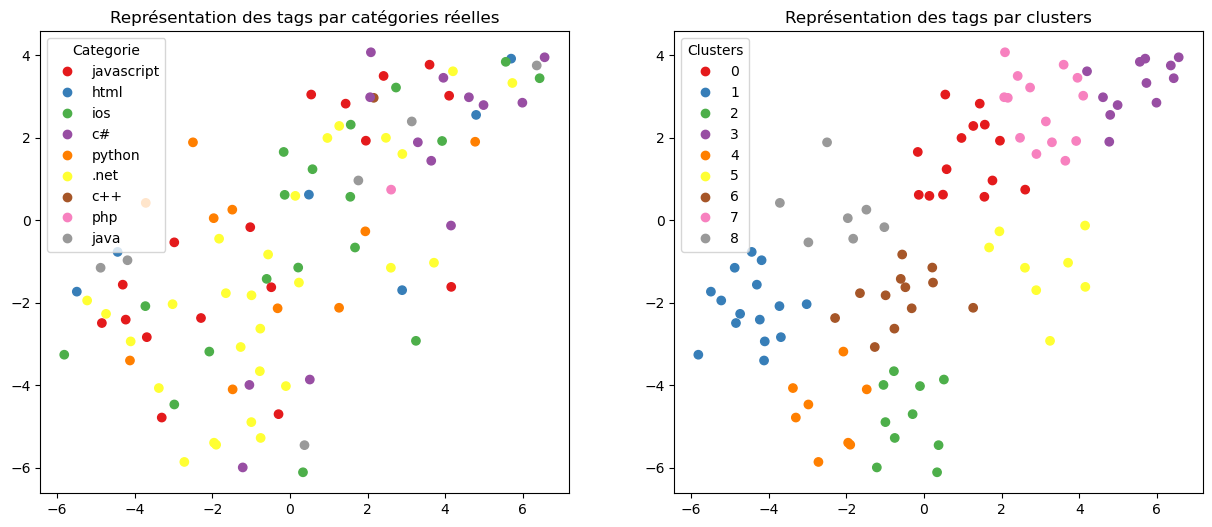

ARI :  0.0142


In [41]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [43]:
pip install tensorflow tensorflow_hub

     -------------------------------------- 100.6/100.6 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [45]:
!pip install tensorflow_text

     ---------------------------------------- 5.0/5.0 MB 1.9 MB/s eta 0:00:00


In [46]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [47]:
sentences = data_T['sentence_dl'].to_list()

In [48]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\omira/.cache\huggingface\hub\models--bert-base-uncased\snapshots\a265f773a47193eed794233aa2a0f0bb6d3eaa63\vocab.t

temps traitement :  5.0


In [49]:
ARI, X_tsne, labels = ARI_fct(features_bert)

C:\Users\omira\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ARI :  0.0414 time :  9.0


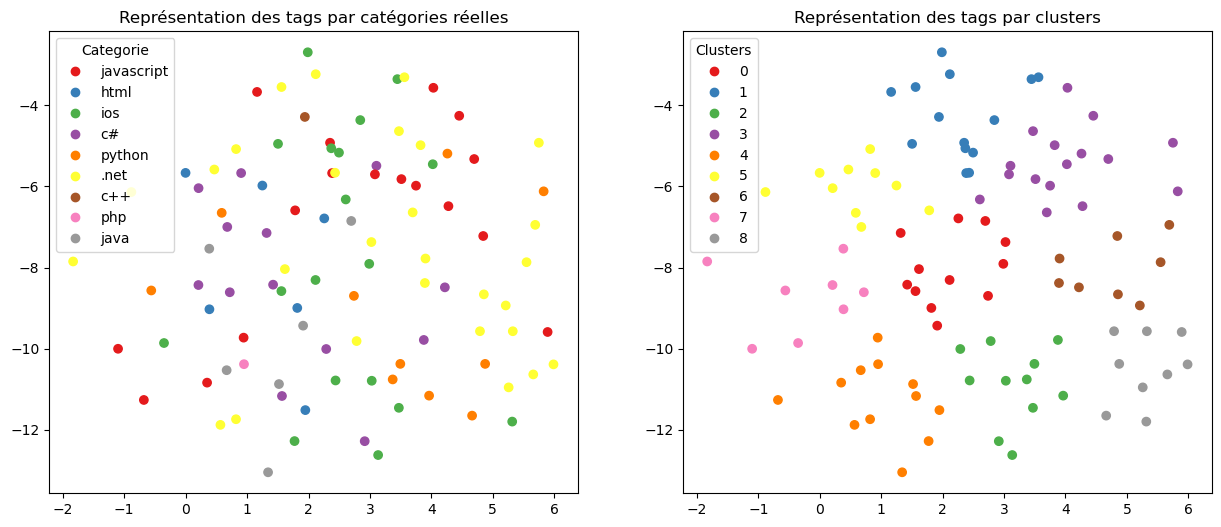

ARI :  0.0414


In [50]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [22]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

RuntimeError: Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
No module named 'keras.saving.hdf5_format'

In [ ]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

In [27]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [28]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [29]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [30]:
features_USE = feature_USE_fct(sentences, batch_size)

In [49]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0647 time :  433.0


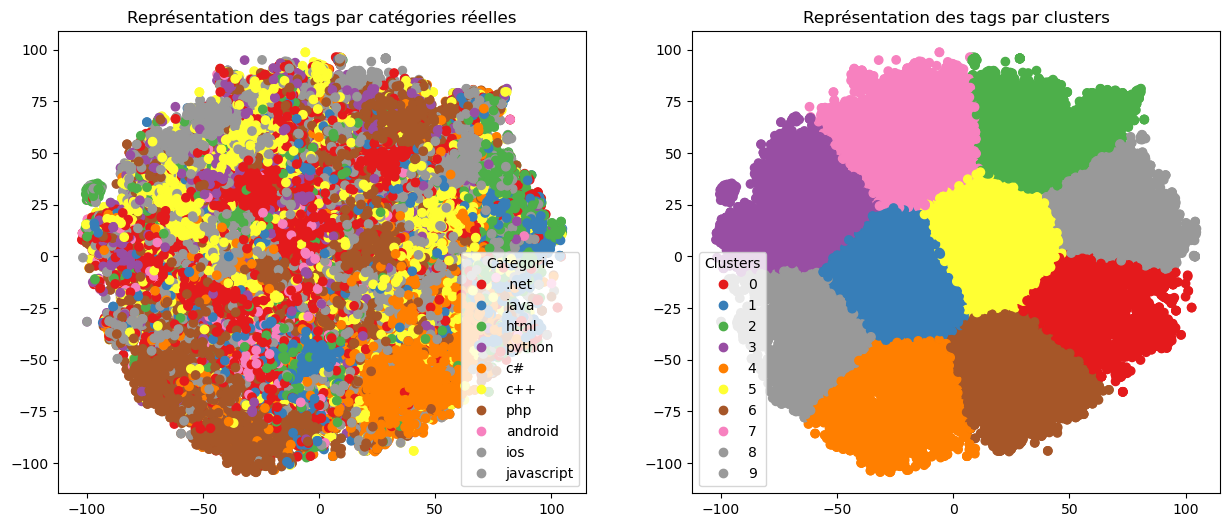

ARI :  0.0647


In [50]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

In [48]:
print(len(y_cat_num))

66760
